# FIT5202 Assessment 2
#### Student Name: Ajay Ganapathy
#### Student ID: 29822270

Date: 18/10/2019

Version: 1.0



## Introduction

This assignment focuses on Machine learning using pyspark. The main goal of this assignment is to predict rainfall tomorrow in Australia using several supervised machine learning algorithms such as Logistic Regression, Gradient Boosting, Decision Trees and Random Forest. This is basically a classification problem where the target/response/dependent variable is categorical i.e. it has 2 classes/categories (Yes/No). In order to do so, we perform various activities which are listed below:

* Importing pyspark and Initializing Spark
* Data Wrangling such as deleting not-so-important columns, detecting and imputing missing values, etc.
* Data Transformation such as converting columns which hold categorical data to numerical values for the machine learning algorithms to learn.
* Creating a feature vector and dividing the data into training and test set 
* Applying machine learning algorithms on the training set, predicting on the test set, reporting the accuracy and error on the test set
* Model evaluation using metrics such as Confusion Matrix.

More details for each task will be given in the following sections.

### Importing the libraries

In [1]:
# create entry points to spark
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as f
from pyspark.sql.functions import isnan, when, count, col, avg, lit
from pyspark.sql.functions import avg
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Part A Spark Initialization and Loading of Data

### Step 01 Importing Spark Session and Initializing Spark

At the start, we import SparkContext from pyspark which is the main entry point of Spark Core functionality. It tells the Spark how to access a cluster. We also import a SparkConf object that contains various information about the Spark application such as the number of processors where we specify 4 cores and the name of the application as 'Rain Forecasting'. Further, we import SparkSession from pyspark.sql which is used to create Dataframes and SQL objects.

In [2]:
#reusing an existing spark context instead of creating one. If there is no existing spark context,
#then create a spark context with 4 local cores in the machine
sc = SparkContext.getOrCreate()
if (sc is None):
    sc = SparkContext(master="local[4]", appName="Rain Forecasting")
spark = SparkSession(sparkContext=sc)

### Step 02 Data Loading

In this step, we load the dataset, which is a comma seperated value file into a Spark dataframe using the created SparkSession object 'spark' and read.csv() function. Further, to check the types of data stored in our dataframe, we use printSchema() function. We also print the total number of records in our dataframe using df.count() function.

In [3]:
#reading the dataset
weather_df = spark.read.csv('weatherAUS.csv', header=True, inferSchema=True)
weather_df.show(3) #displaying top 3 rows

+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|               Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01 00:00:00|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|

In [4]:
#printing the dataset schema
weather_df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [5]:
#displaying the total number of records in the dataset
print("Total number of entries in the Weather dataset :",weather_df.count())

Total number of entries in the Weather dataset : 142193


## Part B Data Wrangling

### Step 03 Deleting Less Informative Columns

In this step, we delete columns that are not contributing much to the task of predicting rainfall. 

Location does not have much importance in predicting whether it will rain tomorrow in Australia. 
Date is more like an index about the information so it does not contribute as well.

Further, we even delete columns such as Evaporation, Sunshine, Cloud9am, Cloud3pm, Temp9am, Temp3pm. The columns are dropped using df.drop() function.

In [6]:
#dropping less important columns
weather_df=weather_df.drop('Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm')
weather_df.show(3)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

In [7]:
#checking the schema of the dataset to see if the columns have been dropped
weather_df.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



### Step 04 Displaying the count of missing values in each column

Here, we simply create a list comprehension where we iterate over each column to find the number of missing values denoted by 'NA'. We display their counts using count() function.

In [8]:
#list comprehension to count missing values in each column
#tabular format representation
weather_df_missing_freq = weather_df.select([f.count(f.when(f.col(i).contains('NA'), i)).alias(i) for i in weather_df.columns])

weather_df_missing_freq.show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



### Step 05 Missing value Imputation

At the start, we replace all the 'NA' values with Null so that it will help us simplify the imputation process further.

In [9]:
#replacing all the NA values by None (identified as null)
weather_df=weather_df.replace('NA',None)
weather_df.show(50)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

By visually analysing the top few rows, we can see that all the 'NA' values in the dataframe has been successfully replaced by null.

Now, we fill the missing data with average value for numeric columns and maximum frequency value for non-numeric columns.

But, all the columns are bydefault in String format. So, first we identify which columns takes on numerical values and cast them to numeric types such as Double.

By visual analysis of the data, we can see that columns such as MinTemp, MaxTemp, Rainfall, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am and Pressure3pm hold numerical values. So, we cast/convert those columns to Double.

In [10]:
#casting the columns that hold numerical values to Double
weather_df=weather_df.withColumn("MinTemp", weather_df["MinTemp"].cast(DoubleType())) \
       .withColumn("MaxTemp", weather_df["MaxTemp"].cast(DoubleType())) \
       .withColumn("Rainfall", weather_df["Rainfall"].cast(DoubleType())) \
       .withColumn("WindGustSpeed", weather_df["WindGustSpeed"].cast(DoubleType())) \
       .withColumn("WindSpeed9am", weather_df["WindSpeed9am"].cast(DoubleType())) \
       .withColumn("WindSpeed3pm", weather_df["WindSpeed3pm"].cast(DoubleType())) \
       .withColumn("Humidity9am", weather_df["Humidity9am"].cast(DoubleType())) \
       .withColumn("Humidity3pm", weather_df["Humidity3pm"].cast(DoubleType())) \
       .withColumn("Pressure9am", weather_df["Pressure9am"].cast(DoubleType())) \
       .withColumn("Pressure3pm", weather_df["Pressure3pm"].cast(DoubleType())) 

In [11]:
weather_df.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



From the above output, we can see that the columns that were listed above are converted to Double.

Since, those columns are converted to numeric type such as Double, we start with the imputation process. We drop the null values from the dataframe using dropna() function and store the updated data in a new dataframe weather_df_no_na . 

In [12]:
#dropping all the nulls
weather_df_no_na=weather_df.dropna()

In [13]:
weather_df_no_na.count()

112925

The missing values still exist in the older dataframe weather_df which we need to impute. So, we select those numeric columns which has the missing values and take the average value of those column observations existing in the new dataframe weather_df_no_na. We further use that value to impute the missing values in the old dataframe weather_df. 

In [14]:
#selecting numerical columns and creating a dataframe
impute_na_df1=weather_df.select('MinTemp' \
        ,'MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm' \
        ,'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm')
impute_na_df1.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|
|   12.9|   25.7|     0.0|         46.0|        19.0|        26.0|       38.0|       30.0|     1007.6|     1008.7|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
only showing top 3 rows



In [15]:
#missing value imputation method for numerical columns also known as Mean Imputation
for x in impute_na_df1.columns:
    meanValue=round(weather_df_no_na.agg(avg(x)).first()[0],2)
    print(x,meanValue)
    impute_na_df1=impute_na_df1.na.fill(meanValue,(x))

MinTemp 12.66
MaxTemp 23.66
Rainfall 2.38
WindGustSpeed 40.79
WindSpeed9am 15.18
WindSpeed3pm 19.5
Humidity9am 67.4
Humidity3pm 50.67
Pressure9am 1017.43
Pressure3pm 1015.05


In [16]:
impute_na_df1.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|
|   12.9|   25.7|     0.0|         46.0|        19.0|        26.0|       38.0|       30.0|     1007.6|     1008.7|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
only showing top 3 rows



Now, we drop the numeric columns with missing values from the old dataframe weather_df and add the same numeric columns from the imputed dataframe impute_na_df1.

In [17]:
#dropping the columns with NA values in older dataframe weather_df
weather_df=weather_df.drop('MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm')
weather_df.printSchema()

root
 |-- WindGustDir: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



We merge the imputed dataframe impute_na_df1 with the older dataframe weather_df on the basis of common column to maintain the latest updated values. 

In [18]:
#creating common column in both the dataframes for the merging process
df1=weather_df.withColumn('row_index', f.monotonically_increasing_id())
df2=impute_na_df1.withColumn('row_index', f.monotonically_increasing_id())

In [19]:
df1.show(3)

+-----------+----------+----------+---------+------------+---------+
|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|row_index|
+-----------+----------+----------+---------+------------+---------+
|          W|         W|       WNW|       No|          No|        0|
|        WNW|       NNW|       WSW|       No|          No|        1|
|        WSW|         W|       WSW|       No|          No|        2|
+-----------+----------+----------+---------+------------+---------+
only showing top 3 rows



In [20]:
df2.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|row_index|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|        0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|        1|
|   12.9|   25.7|     0.0|         46.0|        19.0|        26.0|       38.0|       30.0|     1007.6|     1008.7|        2|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------+
only showing top 3 rows



In [21]:
weather_df.printSchema()

root
 |-- WindGustDir: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [22]:
#merging the imputed dataframe with older dataframe on common generated column ID
weather_df=df1.join(df2, df1.row_index==df2.row_index).drop('row_index')
weather_df.show(3)

+-----------+----------+----------+---------+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|
+-----------+----------+----------+---------+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|          W|         W|       WNW|       No|          No|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|
|        WNW|       NNW|       WSW|       No|          No|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|
|        WSW|         W|       WSW|       No|          No|   12.9|   25.7|     0.0|         46.0|        19.0|        26.0|       38.0|     

In [23]:
#checking if the missing values have been properly imputed for numeric columns
weather_df.select([count(when(col(c).isNull(), c)).alias(c) for c in weather_df.columns]).show()

+-----------+----------+----------+---------+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|
+-----------+----------+----------+---------+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|       9330|     10013|      3778|     1406|           0|      0|      0|       0|            0|           0|           0|          0|          0|          0|          0|
+-----------+----------+----------+---------+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+



From the above output, we can confirm that the missing values have been properly imputed for the numeric columns. We follow the exact same approach for imputing missing values in non-numeric columns. The only key thing is we replace the missing values in a non-numeric column with the most frequent value in that particular column

We start by selecting the non-numeric columns containing missing values and storing it in a dataframe impute_na_df2

In [24]:
#selecting non-numerical columns and creating a dataframe
impute_na_df2=weather_df.select('WindGustDir','WindDir9am','WindDir3pm','RainToday')
impute_na_df2.show(3)

+-----------+----------+----------+---------+
|WindGustDir|WindDir9am|WindDir3pm|RainToday|
+-----------+----------+----------+---------+
|          W|         W|       WNW|       No|
|        WNW|       NNW|       WSW|       No|
|        WSW|         W|       WSW|       No|
+-----------+----------+----------+---------+
only showing top 3 rows



Then, we perform groupby() operation on each of those columns iteratively to get the frequency of observations. We sort the frequency values in descending order and take the top most value as the maximum frequency of occurence for that observation. Thus, we take that observation to impute the null values.

In [25]:
#missing value imputation method for non-numerical column - Mode Imputation
for x in impute_na_df2.columns:
    most_freq_value=impute_na_df2.groupBy(x).count().sort('count', ascending=False).first()[0]
    print(x, most_freq_value)
    impute_na_df2=impute_na_df2.na.fill(most_freq_value, x)

WindGustDir W
WindDir9am N
WindDir3pm SE
RainToday No


In [26]:
#dropping the columns from the old dataframe that has missing values
weather_df=weather_df.drop('WindGustDir','WindDir9am','WindDir3pm','RainToday')
weather_df.printSchema()

root
 |-- RainTomorrow: string (nullable = true)
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- WindGustSpeed: double (nullable = false)
 |-- WindSpeed9am: double (nullable = false)
 |-- WindSpeed3pm: double (nullable = false)
 |-- Humidity9am: double (nullable = false)
 |-- Humidity3pm: double (nullable = false)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)



In [27]:
#creating common column in both the dataframes for the merging process.
df1=weather_df.withColumn('row_index', f.monotonically_increasing_id())
df2=impute_na_df2.withColumn('row_index', f.monotonically_increasing_id())

weather_df= df1.join(df2, df1.row_index==df2.row_index).drop("row_index")
weather_df.show(3)

+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+
|RainTomorrow|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir|WindDir9am|WindDir3pm|RainToday|
+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+
|          No|   20.1|   32.7|     0.0|         48.0|        13.0|        30.0|       56.0|       15.0|     1005.2|     1001.7|        WNW|         N|       WNW|       No|
|          No|   12.0|   24.4|     0.8|         39.0|        17.0|        17.0|       48.0|       28.0|     1006.1|     1005.1|          W|       WNW|       WNW|       No|
|         Yes|   17.2|   28.7|     0.0|         39.0|         4.0|        13.0|       79.0|       41.0|     1016.4|     1011.8|          W| 

In [28]:
#checking if the missing values have been imputed for non-numeric columns
weather_df.select([count(when(col(c).isNull(), c)).alias(c) for c in weather_df.columns]).show()

+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+
|RainTomorrow|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir|WindDir9am|WindDir3pm|RainToday|
+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+
|           0|      0|      0|       0|            0|           0|           0|          0|          0|          0|          0|          0|         0|         0|        0|
+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+



Thus, we can see that all non-numeric columns with missing values has been imputed successfully. Thus, the imputation is complete.

### Step 06 Data Transformation

In this step, we transform the non-numeric columns to numerical columns so that the machine learning algorithm can process it. We do this transformation by using StringIndexer() method to convert them to numbers. In the StringIndexer() method, we specify the input columns to transform and the output columns where we get the transformed data.

In [29]:
#encoding non-numerical columns to columns that hold numerical values
weather_df=StringIndexer(inputCol='WindGustDir',outputCol='WindGustDir-Ind').fit(weather_df).transform(weather_df)
weather_df=StringIndexer(inputCol='WindDir9am',outputCol='WindDir9am-Ind').fit(weather_df).transform(weather_df)
weather_df=StringIndexer(inputCol='WindDir3pm',outputCol='WindDir3pm-Ind').fit(weather_df).transform(weather_df)
weather_df=StringIndexer(inputCol='RainToday',outputCol='RainToday-Ind').fit(weather_df).transform(weather_df)
weather_df=StringIndexer(inputCol='RainTomorrow',outputCol='label').fit(weather_df).transform(weather_df)


weather_df.show(3)

+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+---------------+--------------+--------------+-------------+-----+
|RainTomorrow|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir|WindDir9am|WindDir3pm|RainToday|WindGustDir-Ind|WindDir9am-Ind|WindDir3pm-Ind|RainToday-Ind|label|
+------------+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+----------+----------+---------+---------------+--------------+--------------+-------------+-----+
|          No|   20.1|   32.7|     0.0|         48.0|        13.0|        30.0|       56.0|       15.0|     1005.2|     1001.7|        WNW|         N|       WNW|       No|            9.0|           0.0|           7.0|          0.0|  0.0|
|          No|   12.0|   24.4|     0.8|         

In [30]:
#dropping original columns
weather_df=weather_df.drop('WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow')
weather_df.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+-----+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir-Ind|WindDir9am-Ind|WindDir3pm-Ind|RainToday-Ind|label|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+-----+
|   20.1|   32.7|     0.0|         48.0|        13.0|        30.0|       56.0|       15.0|     1005.2|     1001.7|            9.0|           0.0|           7.0|          0.0|  0.0|
|   12.0|   24.4|     0.8|         39.0|        17.0|        17.0|       48.0|       28.0|     1006.1|     1005.1|            0.0|          14.0|           7.0|          0.0|  0.0|
|   17.2|   28.7|     0.0|         39.0|         4.0|        13.0|       79.0|       41.0|     

Thus, we see that the non-numeric columns have been properly encoded with numerical values.

### Step 07 Building the feature vector and dividing the dataset

The final stage of data preparation is to consolidate all of the predictor columns into a single column i.e. to build the feature vector.
We do this by using VectorAssembler() method as shown below.

In [31]:
#bringing all the columns together to create a feature vector
assembler = VectorAssembler(
    inputCols=["MinTemp", "MaxTemp", "Rainfall",'WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','WindGustDir-Ind','WindDir9am-Ind','WindDir3pm-Ind','RainToday-Ind'],
    outputCol="features")

weather_df = assembler.transform(weather_df)
weather_df.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+-----+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir-Ind|WindDir9am-Ind|WindDir3pm-Ind|RainToday-Ind|label|            features|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+-----+--------------------+
|   20.1|   32.7|     0.0|         48.0|        13.0|        30.0|       56.0|       15.0|     1005.2|     1001.7|            9.0|           0.0|           7.0|          0.0|  0.0|[20.1,32.7,0.0,48...|
|   12.0|   24.4|     0.8|         39.0|        17.0|        17.0|       48.0|       28.0|     1006.1|     1005.1|            0.0|          14.0|           7.0|          0.0|  0.0|[12.0,24.4,0

Further, we divide the dataset into training and test set in the ratio of 70:30 using randomSplit() function. We also set a seed value for reproducable results.

In [32]:
seed = 0  # set seed for reproducibility

#dividing the data into training and test set in 70:30 ratio

trainDF, testDF = weather_df.randomSplit([0.7,0.3],seed)
trainDF.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+-----+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir-Ind|WindDir9am-Ind|WindDir3pm-Ind|RainToday-Ind|label|            features|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+-----+--------------------+
|   -4.9|    3.3|     0.2|         26.0|         6.0|        19.5|       64.0|      50.67|    1017.43|    1015.05|            8.0|           3.0|           0.0|          0.0|  0.0|[-4.9,3.3,0.2,26....|
|   -4.9|   12.2|     0.0|         44.0|         4.0|        24.0|       67.4|       36.0|     1026.6|     1024.7|            5.0|           9.0|           2.0|          0.0|  0.0|[-4.9,12.2,0

In [33]:
#counting the number of observations in training and test set
print("Number of training data: ", trainDF.count())
print("Number of test data: ", testDF.count())

Number of training data:  99594
Number of test data:  42599


## Part C Apply Machine Learning Algorithms

### Step 8 Model Building and Visualization

In this step, we build machine learning models such as Decision Tree Classifier, Random Forest Classifier, Logistic Regression Classifier and Gradient Boosting Classifier to predict the possibility of rainfall tomorrow. 
We fit each classifier one by one and evaluate the model using metrics such as Confusion Matrix which determines the number of missclassifications. 
We also evaluate the model accuracy and error rate on the test set.

<b> Decision Trees <b>

Decision trees and their ensembles are popular methods for machine learning tasks of classification and regression which are widely used to interpret and handle categorical variables for a multiclass problem. The spark.ml implementation supports decision trees for binary and multiclass classification and for regression, using both continuous and categorical features. The implementation partitions data by rows, allowing distributed training with millions or even billions of instances.

First, we create a Decision Tree classifier where we specify the feature, label columns and the maximum depth of the tree. Then, we call .fit() function for the model to learn from the data.

In [34]:
#creating the decision tree classifier
tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

#fitting the model on the training set
tree=tree.fit(trainDF) 

Further, we perform predictions on the test data and compare to known values.

In [35]:
#predicting on the test set
prediction_dt=tree.transform(testDF)

In [36]:
#comparing the predictions with known values
prediction_dt.select('label','prediction','probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.84932043444714...|
|  0.0|       0.0|[0.84932043444714...|
|  0.0|       0.0|[0.84932043444714...|
|  0.0|       0.0|[0.84932043444714...|
|  0.0|       0.0|[0.84932043444714...|
+-----+----------+--------------------+
only showing top 5 rows



Now, we report the accuracy and test error on the test set using a method named MulticlassClassificationEvaluator

In [37]:
# Evaluator method to get metrics such as accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy_dt = round(evaluator.evaluate(prediction_dt),2)
print("Accuracy = ",accuracy_dt)
print("Test Error = %g" % (1.0 - accuracy_dt))

Accuracy =  0.83
Test Error = 0.17


<b> Logistic Regression <b>

Logistic Regression is a Machine Learning algorithm which is used for the classification problems, it is a predictive analysis algorithm and based on the concept of probability. The hypothesis of logistic regression tends it to limit the cost function between 0 and 1. Logistic Regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. 

We perform the same steps as we did to build Decision Tree Classifier.

In [38]:
#creating the logistic regression classifier
logistic = LogisticRegression(featuresCol = 'features', labelCol = 'label',    maxIter=10)

#fitting the model on the training set
logistic = logistic.fit(trainDF)

In [39]:
#predicting on the test set
prediction_log = logistic.transform(testDF)

In [40]:
#comparing the predictions with known  values
prediction_log.select('label','prediction','probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.88247113326762...|
|  0.0|       0.0|[0.76122721635752...|
|  0.0|       0.0|[0.80457114701391...|
|  0.0|       0.0|[0.66702475060071...|
|  0.0|       0.0|[0.89197265999358...|
+-----+----------+--------------------+
only showing top 5 rows



In [41]:
# Evaluator method to get metrics such as accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_logit = round(evaluator.evaluate(prediction_log),2)
print("Accuracy = ",accuracy_logit)
print("Test Error = %g" % (1.0 - accuracy_logit))

Accuracy =  0.82
Test Error = 0.18


<b> Random Forest <b>

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree. In the Random Forests algorithm, each new data point goes through the same process, but now it visits all the different trees in the ensemble, which are grown using random samples of both training data and features.

In [42]:
#creating the random forest classifier

forest = RandomForestClassifier(numTrees=5, labelCol="label",\
featuresCol="features")

#fitting the model on the training set
forest = forest.fit(trainDF)
forest.trees

[DecisionTreeClassificationModel (uid=dtc_e9b7b50396b9) of depth 5 with 37 nodes,
 DecisionTreeClassificationModel (uid=dtc_8a32f37bfccd) of depth 5 with 35 nodes,
 DecisionTreeClassificationModel (uid=dtc_bdb7673c9a6e) of depth 5 with 35 nodes,
 DecisionTreeClassificationModel (uid=dtc_15023e601fa3) of depth 5 with 29 nodes,
 DecisionTreeClassificationModel (uid=dtc_0cf30b23fa5b) of depth 5 with 45 nodes]

In [43]:
#predicting on the test set
prediction_rf = forest.transform(testDF)

In [44]:
#comparing the predictions with known values
prediction_rf.select('label','prediction','probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.88555505199138...|
|  0.0|       0.0|[0.84801451395751...|
|  0.0|       0.0|[0.85821416188567...|
|  0.0|       0.0|[0.89205198937991...|
|  0.0|       0.0|[0.89205198937991...|
+-----+----------+--------------------+
only showing top 5 rows



In [45]:
forest.featureImportances

SparseVector(14, {0: 0.0058, 1: 0.0058, 2: 0.1134, 3: 0.0552, 4: 0.0058, 5: 0.0003, 6: 0.0055, 7: 0.7134, 8: 0.0112, 9: 0.0366, 10: 0.0065, 11: 0.0032, 12: 0.0019, 13: 0.0356})

In [46]:
#evaluator method to get metrics such as accuracy

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_rf = round(evaluator.evaluate(prediction_rf),2)
print("Accuracy = ",accuracy_rf)
print("Test Error = %g" % (1 - accuracy_rf))

Accuracy =  0.83
Test Error = 0.17


<b> Gradient Boosting Tree <b>

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. The objective of any supervised learning algorithm is to define a loss function and minimize it. By using gradient descent and updating our predictions based on a learning rate, we can find the values where Mean Squared Error is minimum. 

In [47]:
#creating the gradient boosting classifier

gbt = GBTClassifier(maxIter=10)

#fitting the model on the training set
gbt = gbt.fit(trainDF)

In [48]:
#predicting on the test set
prediction_gbt = gbt.transform(testDF)

In [49]:
#comparing the predictions with known values
prediction_gbt.select('label','prediction','probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.90895460126015...|
|  0.0|       0.0|[0.89036652651390...|
|  0.0|       0.0|[0.88028985428337...|
|  0.0|       0.0|[0.84332791236144...|
|  0.0|       0.0|[0.92538630896616...|
+-----+----------+--------------------+
only showing top 5 rows



In [50]:
#evaluator method to get the accuracy

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = round(evaluator.evaluate(prediction_gbt),2)
print("Accuracy = ",accuracy_gbt)
print("Test Error = %g" % (1.0 - accuracy_gbt))

Accuracy =  0.84
Test Error = 0.16


<b> Visualizing the Accuracy of all the models <b>

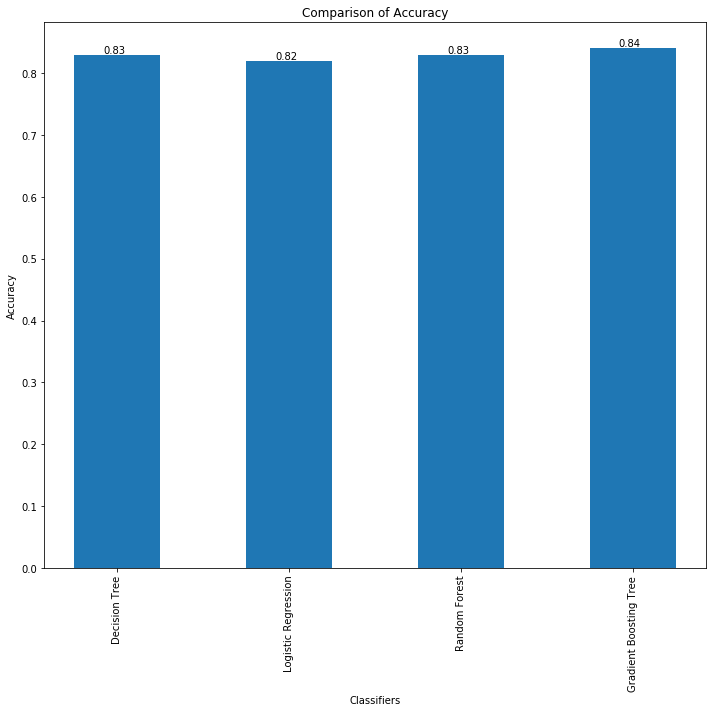

In [51]:
#creating a bar graph

y=[accuracy_dt,accuracy_logit,accuracy_rf,accuracy_gbt]
x=['Decision Tree','Logistic Regression','Random Forest','Gradient Boosting Tree']


bar_width = 0.5

x_pos = np.arange(len(x))
plt.figure(figsize=(10,10))
plt.bar(x_pos, y, bar_width, align='center', color='C0')
plt.xticks(x_pos, x, rotation='vertical')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.tight_layout()


for pos, n in zip(range(4), y):
    plt.annotate(str(round(n,4)), xy=(pos-0.08 , n+0.003))

    
plt.show()

From the above bar chart, we can see that the accuracy generated by all the models are really good with Gradient Boosting and Random Forest leading with same accuracy.

### Step 8 Model Evaluation

The final step is model evaluation. Here, we evaluate the model using a metric named Confusion Matrix which basically tells us about the number of mis-classifications done by the model. 

A confusion matrix consists of 4 values and it is represented in the form of a matrix. These four values represent the following:

- A true positive test result is one that detects the condition when the condition is present. 
- A true negative test result is one that does not detect the condition when the condition is absent. 
- A false positive test result is one that detects the condition when the condition is absent. 
- A false negative test result is one that does not detect the condition when the condition is present. 

We also determine various other measures from the confusion matrix such as precision, recall and f1-score.

- Precision - Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances. 
- Recall - Recall (also known as sensitivity) is the fraction of the total amount of relevant instances that were actually retrieved. 
- F1-Score - The F measure (F1 score or F score) is a measure of a test's accuracy and is defined as the weighted harmonic mean of the precision and recall of the test.

The above statistics are calculated as given in the picture below.


<img src="https://daviddalpiaz.github.io/r4sl/images/confusion.png" >



<img src="https://i.stack.imgur.com/U0hjG.png" >

So, we generate the confusion matrix and various other measures such as Precision, Recall and f1-score of each created model as shown below

<b> Decision Tree Model Evaluation <b>

In [52]:
#extracting the true label and model predictions into an key-value pair RDD
prediction_dt_rdd = prediction_dt.select(['label', 'prediction']).rdd.map(lambda x: (x[1], x[0]))

#instantiating a MulticlassMetrics object 
metrics = MulticlassMetrics(prediction_dt_rdd)

# displaying the confusion Matrix
print("The confusion matrix of Decision Tree Model is as follows: \n")
print(metrics.confusionMatrix().toArray())

# Retrieving the statistics from confusion matrix
confusion_matrix=metrics.confusionMatrix().toArray()
accuracy_dt=(confusion_matrix[0][0]+confusion_matrix[1][1])/confusion_matrix.sum()
recall_dt=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[0][1])
precision_dt=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[1][0]) 
f1score_dt = (2*precision_dt*recall_dt)/(precision_dt+recall_dt)

print("--------------\nDecision Tree Model Metrics\n")
print("Accuracy = %s" % round(accuracy_dt,2))
print("Precision = %s" % round(precision_dt,2))
print("Recall = %s" % round(recall_dt,2))
print("F1 Score = %s" % round(f1score_dt,2))

The confusion matrix of Decision Tree Model is as follows: 

[[32272.   979.]
 [ 6287.  3061.]]
--------------
Decision Tree Model Metrics

Accuracy = 0.83
Precision = 0.33
Recall = 0.76
F1 Score = 0.46


<b> Logistic Regression Model Evaluation <b>

In [53]:
#extracting the true label and model predictions into an key-value pair RDD
prediction_log_rdd = prediction_log.select(['label', 'prediction']).rdd.map(lambda x: (x[1], x[0]))

#instantiating a MulticlassMetrics object 
metrics = MulticlassMetrics(prediction_log_rdd)

# displaying the confusion Matrix
print("The confusion matrix of Logistic Regression Model is as follows: \n")
print(metrics.confusionMatrix().toArray())

# Retrieving the statistics from confusion matrix
confusion_matrix=metrics.confusionMatrix().toArray()
accuracy_log=(confusion_matrix[0][0]+confusion_matrix[1][1])/confusion_matrix.sum()
recall_log=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[0][1])
precision_log=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[1][0]) 
f1score_log = (2*precision_log*recall_log)/(precision_log+recall_log)

print("--------------\nLogistic Regression Model Metrics\n")
print("Accuracy = %s" % round(accuracy_log,2))
print("Precision = %s" % round(precision_log,2))
print("Recall = %s" % round(recall_log,2))
print("F1 Score = %s" % round(f1score_log,2))

The confusion matrix of Logistic Regression Model is as follows: 

[[30847.  2404.]
 [ 5396.  3952.]]
--------------
Logistic Regression Model Metrics

Accuracy = 0.82
Precision = 0.42
Recall = 0.62
F1 Score = 0.5


<b> Random Forest Model Evaluation <b>

In [54]:
#extracting the true label and model predictions into an key-value pair RDD
prediction_rf_rdd = prediction_rf.select(['label', 'prediction']).rdd.map(lambda x: (x[1], x[0]))

#instantiating a MulticlassMetrics object 
metrics = MulticlassMetrics(prediction_rf_rdd)

# displaying the confusion Matrix
print("The confusion matrix of Random Forest Model is as follows: \n")
print(metrics.confusionMatrix().toArray())

# Retrieving the statistics from confusion matrix
confusion_matrix=metrics.confusionMatrix().toArray()
accuracy_rf=(confusion_matrix[0][0]+confusion_matrix[1][1])/confusion_matrix.sum()
recall_rf=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[0][1])
precision_rf=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[1][0]) 
f1score_rf = (2*precision_rf*recall_rf)/(precision_rf+recall_rf)

print("--------------\nRandom Forest Model Metrics\n")
print("Accuracy = %s" % round(accuracy_rf,2))
print("Precision = %s" % round(precision_rf,2))
print("Recall = %s" % round(recall_rf,2))
print("F1 Score = %s" % round(f1score_rf,2))

The confusion matrix of Random Forest Model is as follows: 

[[31950.  1301.]
 [ 5737.  3611.]]
--------------
Random Forest Model Metrics

Accuracy = 0.83
Precision = 0.39
Recall = 0.74
F1 Score = 0.51


<b> Gradient Boosting Model Evaluation <b>

In [55]:
#extracting the true label and model predictions into an key-value pair RDD
prediction_gbt_rdd = prediction_gbt.select(['label', 'prediction']).rdd.map(lambda x: (x[1], x[0]))

#instantiating a MulticlassMetrics object 
metrics = MulticlassMetrics(prediction_gbt_rdd)

# displaying the confusion Matrix
print("The confusion matrix of Gradient Boosting Model is as follows: \n")
print(metrics.confusionMatrix().toArray())

# Retrieving the statistics from confusion matrix
confusion_matrix=metrics.confusionMatrix().toArray()
accuracy_gbt=(confusion_matrix[0][0]+confusion_matrix[1][1])/confusion_matrix.sum()
recall_gbt=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[0][1])
precision_gbt=(confusion_matrix[1][1])/(confusion_matrix[1][1]+confusion_matrix[1][0]) 
f1score_gbt = (2*precision_gbt*recall_gbt)/(precision_gbt+recall_gbt)

print("--------------\nGradient Boosting Model Metrics\n")
print("Accuracy = %s" % round(accuracy_gbt,2))
print("Precision = %s" % round(precision_gbt,2))
print("Recall = %s" % round(recall_gbt,2))
print("F1 Score = %s" % round(f1score_gbt,2))

The confusion matrix of Gradient Boosting Model is as follows: 

[[31612.  1639.]
 [ 5074.  4274.]]
--------------
Gradient Boosting Model Metrics

Accuracy = 0.84
Precision = 0.46
Recall = 0.72
F1 Score = 0.56


To summarise, the number of mis-classifications done by Gradient Boosting and Random Forest is less compared to Logistic Regression and Decision trees, thereby generating high accuracy.

<b> Strategies for Improving the Accuracy <b>

Below are the strategies for improving the accuracy of the models

* <u> Add More Data </u>: Having more data is always a good idea. It allows the data to tell for itself instead of relying on assumptions and weak correlations. Presence of more data results in better and accurate models.<br><br>

* <u> More Significant Wrangling such as Outlier Detection </u>: Clean data helps to achieve the trade-off between bias and variance which improves the accuracy. Presence of outliers reduces the accuracy of the model and leads to a biased model. It leads to inaccurate predictions. This is because we don’t analyse the behavior and relationship with other variables correctly. So, it is important to treat the outlier values well.<br><br>

* <u> Feature Engineering </u>: Feature engineering such as feature scaling (changing the scale of variable from original scale to a scale between 0 and 1) leads to a normally distributed data. Machine learning algorithms work well with normally distributed data having a Gaussian Distribution. Also, deriving new variables from existing variables known as feature creation helps to unleash the hidden relationship of a data set.<br><br>

* <u> Feature Selection </u>: Selecting relevant/important features that explains the target/response variable is the most important one. It is better to remove irrelevant features that do not have any association with the target. Various strategies can be used for feature selection such as removing features having low variance, correlation analysis or getting an idea of the domain knowledge through domain experts and then removing the features that are less important ones.<br><br>

* <u> Fine Tuning of Parameters </u>: Fine tuning of parameters helps us to find the optimum value of each parameter which is used to boost the accuracy of the model. For example: In random forest, we have various parameters like max_features, number_trees, random_state, oob_score and others which is shown below:

<b><i> RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False,class_weight=None) </i></b>

* <u> Use of Ensemble Methods </u>: Using Ensembling methods such as Bagging (Bootstrap Aggregation) and Boosting helps to produce better results by combining the result of multiple weak models, thereby increasing the accuracy of the model.


And finally,

* <u> Cross Validation </u>: Using Cross Validation methods, like K-fold cross validaion and Leave One Out Cross Validationb (LOOCV), we can train the data across several different samples covering the entire subset of training data thereby providing the best results.

### Conclusion

Through this assignment, we have learnt how to use Machine Learning concepts using Apache Spark. We saw the performance of 4 different machine learning models on the weather data which produced accurate results. At the end, we discussed different strategies of improving the accuracy of the machine learning models. 